In [12]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, random, pickle, json, itertools
import cv2
from IPython.display import SVG

from tensorflow.keras.utils import plot_model#, model_to_dot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Add, Input, Conv2D, Dropout, Activation, BatchNormalization, MaxPooling2D, ZeroPadding2D, AveragePooling2D, Flatten, Dense)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import *
from tqdm import tqdm

In [13]:
def conv_block(X, k, filters, stage, block, s=2):
    conv_base_name = 'conv_' + str(stage) + block + '_branch'
    bn_base_name = 'bn_' + str(stage) + block + "_branch"

    F1 = filters

    X = Conv2D(filters=F1, kernel_size=(k, k), strides=(s, s),
               padding='same', name=conv_base_name + '2a')(X)
    X = BatchNormalization(name=bn_base_name + '2a')(X)
    X = Activation('relu')(X)

    return X
    pass

In [14]:

def basic_model(input_shape,classes):

    X_input = Input(input_shape)

    X = ZeroPadding2D((5,5))(X_input)

    X = Conv2D(16,(3,3),strides=(2,2),name='conv1',padding="same")(X)
    X = BatchNormalization(name='bn_conv1')(X)

    # stage 2
    X = conv_block(X,3,32,2,block='A',s=1)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)

#     Stage 3
    X = conv_block(X,5,32,3,block='A',s=2)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)

#     Stage 4
    X = conv_block(X,3,64,4,block='A',s=1)
    X = MaxPooling2D((2,2))(X)
    X = Dropout(0.25)(X)

#   Output Layer
    X = Flatten()(X)
    X = Dense(64)(X)
    X = Dropout(0.5)(X)

    X = Dense(128)(X)
    X = Activation("relu")(X)

    X = Dense(classes,activation="softmax",name="fc"+str(classes))(X)

    model = Model(inputs=X_input,outputs=X,name='Feature_Extraction_and_FC')

    return model
    pass

In [15]:
class_names = ["no-ship","ship"]

class_name_labels = {class_name:i for i,class_name in enumerate(class_names)}

num_classes = len(class_names)
class_name_labels

{'no-ship': 0, 'ship': 1}

In [16]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

In [17]:
def load_data():
    print("Loading ship data")
    ships_path = os.path.join('../../data/raw/','shipsnet.json')
    with open(ships_path) as file:
        dataset = json.load(file)

    labels = np.array(dataset["labels"]).astype("float32")

    img_length = 80
    images = np.array(dataset["data"]).astype("uint8")
    images = images.reshape(-1, 3, img_length, img_length).transpose([0, 2, 3, 1])
    images = [cv2.cvtColor(img,cv2.COLOR_BGR2RGB) for img in images]
    images = [cv2.resize(img, (48,48)) for img in images]
    images = np.array(images,dtype=np.float32)/255.0
    print("Data loaded")
    return images, labels


In [18]:
(images, labels) = load_data()
images.shape, labels.shape


Loading ship data
Data loaded


((4000, 48, 48, 3), (4000,))

In [19]:
labels = to_categorical(labels)

In [20]:
np.random.seed(42)
np.random.shuffle(images)

np.random.seed(42)
np.random.shuffle(labels)

In [21]:

total_count = len(images)
total_count

train = int(0.8*total_count)
test = int(0.2*total_count)

train_images, train_labels = images[:train], labels[:train]
test_images, test_labels = images[-test:], labels[-test:]

train_images.shape, test_images.shape

((3200, 48, 48, 3), (800, 48, 48, 3))

In [22]:
batch_size=16

IGD = ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         rotation_range=20,
                         validation_split=0.2)
IGD.fit(train_images)

In [23]:
train_generator = IGD.flow(
    train_images,
    train_labels,
    batch_size=batch_size,
    seed = 42,
    shuffle=True,
    subset="training"
    )

val_generator = IGD.flow(
    train_images,
    train_labels,
    batch_size=batch_size,
    seed = 42,
    shuffle=True,
    subset="validation",
    )

In [24]:
model = basic_model(input_shape=(48,48,3),classes=2)

In [25]:

model.summary()


Model: "Feature_Extraction_and_FC"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 58, 58, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 29, 29, 16)        448       
_________________________________________________________________
bn_conv1 (BatchNormalization (None, 29, 29, 16)        64        
_________________________________________________________________
conv_2A_branch2a (Conv2D)    (None, 29, 29, 32)        4640      
_________________________________________________________________
bn_2A_branch2a (BatchNormali (None, 29, 29, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 29, 2

In [26]:
opt = Adam(lr=1e-4)
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['acc'])

In [27]:
checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_acc',verbose=1,save_best_only=True,mode='max')
logs = TensorBoard("logs")


In [28]:
count_labels = train_labels.sum(axis=0)

classTotals = train_labels.sum(axis=0)
classWeight = {}

for i in range(0,len(classTotals)):
    classWeight[i] = classTotals.max()/classTotals[i]
    pass

classWeight


{0: 1.0, 1: 2.9263804}

In [29]:
epochs = 150

history = model.fit_generator(train_generator, 
                              steps_per_epoch=train_generator.n//batch_size,
                              epochs=epochs,
                              validation_data=val_generator,
                              validation_steps=val_generator.n//batch_size,
                              callbacks=[checkpoint, logs],
                              class_weight=classWeight,
                              verbose=1)


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/150
  1/160 [..............................] - ETA: 0s - loss: 1.7573 - acc: 0.1250WARNING:tensorflow:From c:\users\victo\aarhus universitet\test - dokumenter\elektronik\noter elektronik\elektronik 6. semester\itmal\itmal - exercises\venv\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
160/160 [==============================] - ETA: 0s - loss: 1.2361 - acc: 0.5238
Epoch 00001: val_acc improved from -inf to 0.61094, saving model to model_weights.h5
160/160 [==============================] - 7s 45ms/step - loss: 1.2361 - acc: 0.5238 - val_loss: 0.6867 - val_acc: 0.6109
Epoch 2/150
160/160 [==============================] - ETA: 0s - loss: 1.0227 - acc: 0.6059
Epoch 00002: val_acc improved from 0.61094 to 0.79062, saving mod

160/160 [==============================] - ETA: 0s - loss: 0.2714 - acc: 0.9328
Epoch 00027: val_acc did not improve from 0.95938
160/160 [==============================] - 6s 40ms/step - loss: 0.2714 - acc: 0.9328 - val_loss: 0.1191 - val_acc: 0.9563
Epoch 28/150
160/160 [==============================] - ETA: 0s - loss: 0.2446 - acc: 0.9371
Epoch 00028: val_acc did not improve from 0.95938
160/160 [==============================] - 6s 40ms/step - loss: 0.2446 - acc: 0.9371 - val_loss: 0.1063 - val_acc: 0.9594
Epoch 29/150
160/160 [==============================] - ETA: 0s - loss: 0.2373 - acc: 0.9363
Epoch 00029: val_acc improved from 0.95938 to 0.96562, saving model to model_weights.h5
160/160 [==============================] - 7s 41ms/step - loss: 0.2373 - acc: 0.9363 - val_loss: 0.0950 - val_acc: 0.9656
Epoch 30/150
159/160 [============================>.] - ETA: 0s - loss: 0.2290 - acc: 0.9399
Epoch 00030: val_acc did not improve from 0.96562
160/160 [============================

Epoch 58/150
159/160 [============================>.] - ETA: 0s - loss: 0.1269 - acc: 0.9646
Epoch 00058: val_acc improved from 0.97656 to 0.98125, saving model to model_weights.h5
160/160 [==============================] - 6s 36ms/step - loss: 0.1266 - acc: 0.9648 - val_loss: 0.0490 - val_acc: 0.9812
Epoch 59/150
160/160 [==============================] - ETA: 0s - loss: 0.1277 - acc: 0.9668
Epoch 00059: val_acc did not improve from 0.98125
160/160 [==============================] - 6s 38ms/step - loss: 0.1277 - acc: 0.9668 - val_loss: 0.0528 - val_acc: 0.9766
Epoch 60/150
160/160 [==============================] - ETA: 0s - loss: 0.1418 - acc: 0.9605
Epoch 00060: val_acc did not improve from 0.98125
160/160 [==============================] - 6s 36ms/step - loss: 0.1418 - acc: 0.9605 - val_loss: 0.0461 - val_acc: 0.9812
Epoch 61/150
159/160 [============================>.] - ETA: 0s - loss: 0.1468 - acc: 0.9568- ETA: 0s - loss: 0.1473 - 
Epoch 00061: val_acc did not improve from 0.981

Epoch 89/150
159/160 [============================>.] - ETA: 0s - loss: 0.1024 - acc: 0.9744
Epoch 00089: val_acc did not improve from 0.98750
160/160 [==============================] - 6s 36ms/step - loss: 0.1019 - acc: 0.9746 - val_loss: 0.0377 - val_acc: 0.9828
Epoch 90/150
160/160 [==============================] - ETA: 0s - loss: 0.0860 - acc: 0.9758
Epoch 00090: val_acc improved from 0.98750 to 0.99219, saving model to model_weights.h5
160/160 [==============================] - 6s 36ms/step - loss: 0.0860 - acc: 0.9758 - val_loss: 0.0220 - val_acc: 0.9922
Epoch 91/150
159/160 [============================>.] - ETA: 0s - loss: 0.0967 - acc: 0.9737
Epoch 00091: val_acc did not improve from 0.99219
160/160 [==============================] - 6s 37ms/step - loss: 0.0981 - acc: 0.9730 - val_loss: 0.0336 - val_acc: 0.9859
Epoch 92/150
159/160 [============================>.] - ETA: 0s - loss: 0.1028 - acc: 0.9748
Epoch 00092: val_acc did not improve from 0.99219
160/160 [===============

Epoch 120/150
159/160 [============================>.] - ETA: 0s - loss: 0.0874 - acc: 0.9768
Epoch 00120: val_acc did not improve from 0.99219
160/160 [==============================] - 7s 43ms/step - loss: 0.0869 - acc: 0.9770 - val_loss: 0.0466 - val_acc: 0.9828
Epoch 121/150
160/160 [==============================] - ETA: 0s - loss: 0.0770 - acc: 0.9820
Epoch 00121: val_acc did not improve from 0.99219
160/160 [==============================] - 7s 41ms/step - loss: 0.0770 - acc: 0.9820 - val_loss: 0.0469 - val_acc: 0.9828
Epoch 122/150
159/160 [============================>.] - ETA: 0s - loss: 0.0696 - acc: 0.9803
Epoch 00122: val_acc did not improve from 0.99219
160/160 [==============================] - 7s 43ms/step - loss: 0.0713 - acc: 0.9801 - val_loss: 0.0248 - val_acc: 0.9906
Epoch 123/150
160/160 [==============================] - ETA: 0s - loss: 0.0811 - acc: 0.9785
Epoch 00123: val_acc did not improve from 0.99219
160/160 [==============================] - 7s 41ms/step - 

In [30]:
def show_final_history(history):

    plt.style.use("ggplot")
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')
    ax[0].plot(history.history['loss'],label='Train Loss')
    ax[0].plot(history.history['val_loss'],label='Validation Loss')
    ax[1].plot(history.history['acc'],label='Train Accuracy')
    ax[1].plot(history.history['val_acc'],label='Validation Accuracy')

    ax[0].legend(loc='upper right')
    ax[1].legend(loc='lower right')
    plt.show();
    pass


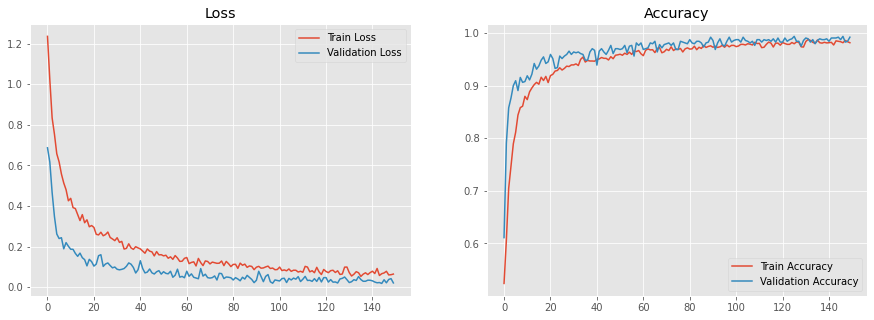

25/25 [==============================] - 0s 10ms/step - loss: 0.0256 - acc: 0.9887
Final test accuracy: 0.9887499809265137


In [31]:
show_final_history(history)

score, acc = model.evaluate(test_images, test_labels,)
print(f"Final test accuracy: {acc}")

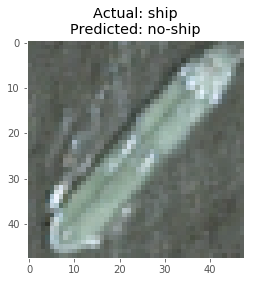

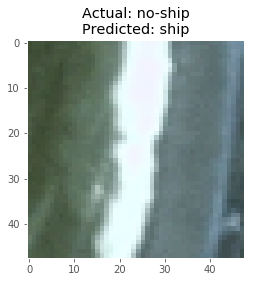

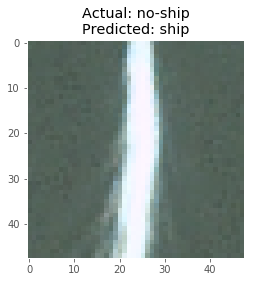

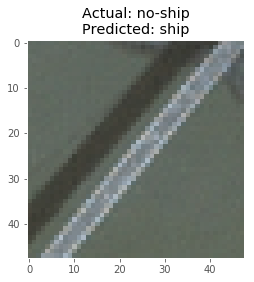

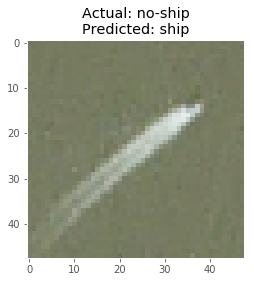

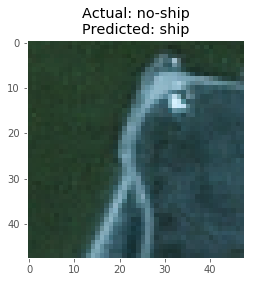

In [22]:
test_actual = np.argmax(test_labels,axis=1)
test_pred = model.predict(test_images)
test_pred = np.argmax(test_pred,axis=1)
test_pred.shape
rnd_idx = random.sample(range(0,400),10)
class_labels = {i:class_name for (class_name,i) in class_name_labels.items()}
class_labels

# fig, ax = plt.subplots(2,5,figsize=(5,5))

for i,idx in enumerate(rnd_idx):

    plt.imshow(test_images[idx])
    plt.title("Actual: {}\nPredicted: {}".format(class_labels[test_actual[idx]],class_labels[test_pred[idx]]))
    plt.grid(None)
    plt.show()
    pass


def plot_confusion_matrix(cm,classes,title='Confusion Matrix',cmap=plt.cm.Blues):

#     np.seterr(divide='ignore',invalid='ignore')
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        pass

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass

test_actual = np.argmax(test_labels,axis=1)

cnf_mat_test = confusion_matrix(test_actual, test_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat_test,classes=class_names)
plt.grid(None)
plt.show()